In [8]:
import os
GPUS = [0]
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = ', '.join([str(i) for i in GPUS])

In [3]:
import numpy as np
import pandas as pd
import keras
import matplotlib.pyplot as plt

VOCAB_SIZE=30000
MAX_SEQUENCE_LENGTH=100
EMBEDDING_DIM = 300

/home/t4/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [7]:
df = pd.read_csv('cleaned_dataset.csv')
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,explanation edit make my username hardcore met...,0,0,0,0,0,0
1,000103f0d9cfb60f,d'aww he match background colour i be seemingl...,0,0,0,0,0,0
2,000113f07ec002fd,hey man i be really not try edit war it be guy...,0,0,0,0,0,0
3,0001b41b1c6bb37e,i not make real suggestion improvement i wonde...,0,0,0,0,0,0
4,0001d958c54c6e35,you sir be my hero chance you remember page be,0,0,0,0,0,0


In [9]:
X = df['comment_text'].astype(str).values
Y = df.iloc[:,2:].values
y = np.any(Y,axis=1)

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=VOCAB_SIZE)
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)
word_index = tokenizer.word_index

x = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

#Word Embedding
def getEmbeddings(path):
    embeddings_index = {}
    with open(path,'r') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index

embeddings_index = getEmbeddings('crawl-300d-2M.vec')
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [10]:
#From KERNEL
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

X = df['comment_text'].astype(str).values
Y = df.iloc[:,2:].values
y = np.any(Y,axis=1)

EMBEDDING_FILE = 'crawl-300d-2M.vec'

max_features = 30000
maxlen = 100
embed_size = 300

tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(X))
X = tokenizer.texts_to_sequences(X)
x = pad_sequences(X, maxlen=maxlen)


def get_coefs(word, *arr): return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(EMBEDDING_FILE))

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.zeros((nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

In [14]:
from keras.layers import *
from keras.models import Model
from keras.optimizers import *
from keras.callbacks import Callback
from sklearn.metrics import roc_auc_score
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import train_test_split, GridSearchCV

def get_model(lr=0.001):
    inp = Input(shape=(MAX_SEQUENCE_LENGTH,))
    x = Embedding(max_features,#len(word_index) + 1
                    EMBEDDING_DIM,
                    weights=[embedding_matrix],
                    input_length=MAX_SEQUENCE_LENGTH,
                    trainable=False)(inp)
    x = SpatialDropout1D(0.2)(x)
    x = Bidirectional(GRU(80, return_sequences=True))(x)
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
#     conv = Conv1D(4,3)(x)
#     conv = MaxPooling1D()(conv)
#     conv = Flatten()(conv)
    conc = concatenate([avg_pool, max_pool])
    outp = Dense(80, activation="relu")(conc)
    outp = Dense(1, activation='sigmoid')(outp)
    model = Model(inputs=inp, outputs=outp)
    optim = Adam(lr=lr)
    model.compile(loss='binary_crossentropy',
                    optimizer=optim,
                    metrics=['accuracy'])
    return model

# X_train,X_val,Y_train,Y_val = train_test_split(x,y,test_size=0.05)
#Y_train = y_train.astype(int)
#y_train = pd.get_dummies(y_train).values
#print(y_train)
#y_val = y_val.astype(int)
#y_val = pd.get_dummies(y_val).values

# RocAuc = RocAucEvaluation(validation_data=(X_val, Y_val), interval=1)
# callbacks=[RocAuc]
# clf = KerasClassifier(build_fn=get_model,epochs=3,validation_data=(X_val,Y_val),callbacks=callbacks)
lrs=[0.01,0.005,0.001,0.0005,0.0001]
batch_sizes=[32,64,128,256,512]
# param_grid = dict(lr=lrs,batch_size=batch_sizes)
# grid = GridSearchCV(estimator=clf,param_grid=param_grid)
# grid_results = grid.fit(X_train,Y_train)

In [15]:
class RocAucEvaluation(Callback):
    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__()

        self.interval = interval
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=0)
            score = roc_auc_score(self.y_val, y_pred)
            print("\n ROC-AUC - epoch: %d - score: %.6f \n" % (epoch+1, score))

In [16]:
from sklearn.model_selection import train_test_split

x_train,x_val,y_train,y_val = train_test_split(x,y,test_size=0.05)
RocAuc = RocAucEvaluation(validation_data=(x_val, y_val), interval=1)
callbacks=[RocAuc]

In [ ]:
model = get_model(lr=0.005)
model.fit(x_train,y_train,batch_size=512,epochs=2,validation_data=(x_val,y_val),callbacks=callbacks)
model.save_weights('version-3-weights.h5')

In [ ]:
model = get_model(lr=0.0005)
model.load_weights('version-3-weights.h5')
model.fit(x_train,y_train,batch_size=512,epochs=1,validation_data=(x_val,y_val),callbacks=callbacks)
model.save_weights('version-3-weights.h5')
model.save('version-3.h5')

In [ ]:
import pickle
with open('tokenizer.txt','wb+') as f:
    pickle.dump(tokenizer,f)
    f.close()

# Evaluating the model

In [4]:
model = keras.models.load_model('version-3.h5')

In [17]:
y_pred = model.predict(x_val)

In [29]:
rounded_y = np.round(y_pred)

In [34]:
from sklearn.metrics import confusion_matrix,classification_report,roc_auc_score,roc_curve,auc
confusion_matrix(y_val,rounded_y)

array([[7057,   85],
       [ 145,  692]])

In [32]:
print(classification_report(y_val,rounded_y))

             precision    recall  f1-score   support

      False       0.98      0.99      0.98      7142
       True       0.89      0.83      0.86       837

avg / total       0.97      0.97      0.97      7979



In [33]:
print(roc_auc_score(y_val,y_pred))

0.9869837068620277


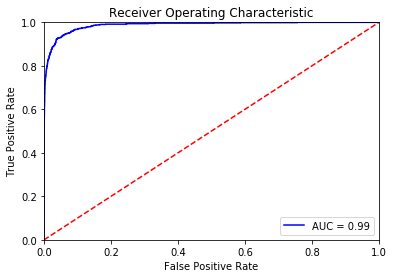

In [35]:

fpr, tpr, threshold = roc_curve(y_val, y_pred)
roc_auc = auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()